# Bayesian neural network
In this notebook, we make use of HMC to estimate the posterior predictive distribution of a 1-dimensional regression problem and the rotating MNIST (rMNIST). We compare the mean absolute error between the mean posterior predictive and the true value for both datasets.

In [1]:
import jax
import blackjax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from typing import Callable
from jaxtyping import Float, Array
from dataclasses import dataclass
from jax.flatten_util import ravel_pytree

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from rebayes.utils import datasets
from rebayes import hamiltonian_monte_carlo as rhmc

In [3]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)
key_warmup, key_train = jax.random.split(key_train)

In [41]:
class MLP(nn.Module):
    dim_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x

# 1D-regression

In [22]:
def plot_posterior_predictive(params, evalfn, xrange):
    yhat_samples = jax.vmap(evalfn, (0, None))(params, xrange).squeeze()
    
    yhat_mean = yhat_samples.mean(axis=0)
    yhat_std = yhat_samples.std(axis=0)
    
    plt.plot(xrange, yhat_mean, c="tab:blue", linewidth=2, label="mean pp")
    plt.plot(xrange, yhat_mean + 2 * yhat_std, c="tab:gray", linewidth=1)
    plt.plot(xrange, yhat_mean - 2 * yhat_std, c="tab:gray", linewidth=1)

    for sample in yhat_samples:
        plt.plot(xrange, sample, c="tab:gray", alpha=0.05)

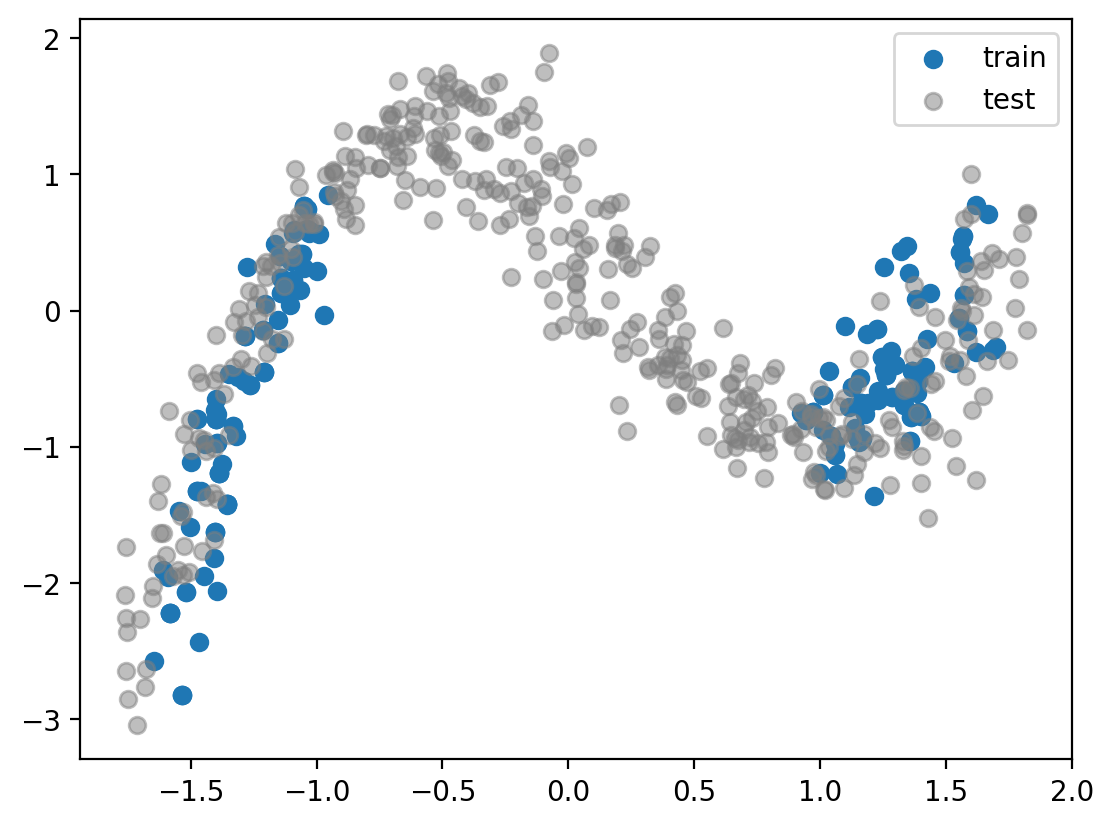

In [38]:
num_train, num_test = 200, 400
train, test = datasets.load_1d_synthetic_dataset(num_train, num_test, sort_data=False)
(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, c="tab:gray", label="test", alpha=0.5, )
plt.legend()

## Model setup

In [40]:
dim_input = 1
batch_size = 100
batch = (batch_size, dim_input)
model = MLP(1, activation=nn.elu)
batch = jnp.ones(batch)

params_init = model.init(key_init, batch)

In [41]:
num_warmup = 200
num_samples = 100
priors = rhmc.PriorParam(scale_obs=2.0, scale_weight=0.5)

In [44]:
list_eval = list(range(2, 202, 2))

In [ ]:
%%time
rb_model = rhmc.RebayesHMC(model.apply, priors, rhmc.log_joint, num_warmup, num_samples)
params_hist = rb_model.scan(key_train, params_init, X_train, y_train, eval_steps=list_eval)

CPU times: user 10min, sys: 1min 53s, total: 11min 53s
Wall time: 7min 56s


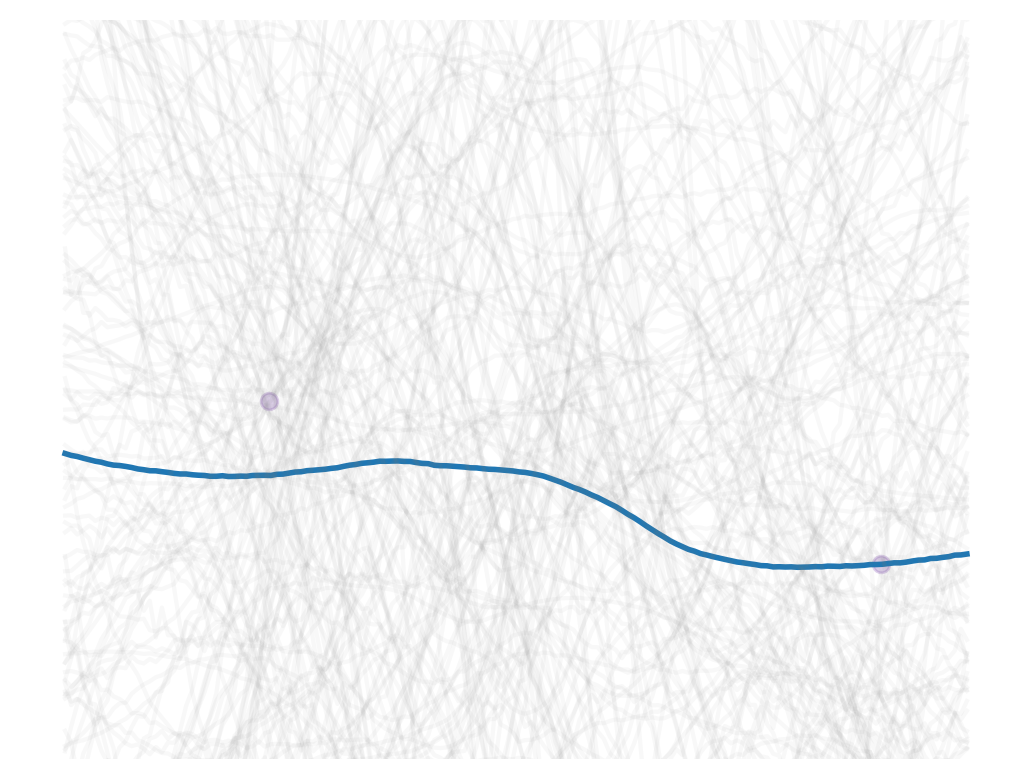

In [88]:
%%time
fig, ax = plt.subplots()

xmin, xmax = -2, 2
num_steps = 150
x_eval = jnp.linspace(xmin, xmax, num_steps)

def animate_ppd(n):
    ax.cla()
    n_eval = list_eval[n]
    X_eval = X_train[:n_eval]
    y_eval = y_train[:n_eval]

    plt.scatter(X_eval, y_eval, alpha=0.3, c="tab:purple", label="train")
    ymin, ymax = plt.ylim()
    plot_posterior_predictive(params_hist[n_eval], model.apply, x_eval[:, None])
    plt.ylim(ymin - 1.0, ymax + 2.0)
    plt.legend(loc="upper right")
    plt.title("BNN Gauss — posterior samples");
    return ax

frames = list(range(len(params_hist)))
anim1 = animation.FuncAnimation(fig, animate_ppd, frames=frames)
anim1.save("animation-hmc.mp4", dpi=100, bitrate=-1, fps=10)

### Evaluation metrics

In [84]:
sampled_params = params_hist[200]

##### Mean absolute error

In [85]:
yhat_test = rb_model.predict_obs(sampled_params, X_test).squeeze()
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(0.32130995, dtype=float32)

##### Negative marginal log-likelihood

The marginal log-likelihood can be approximated as
$$
\begin{aligned}
    \log p(y \vert x, \cal D)
    &= \log\int p({\bf w} \vert \cal D) p(y \vert x, {\bf w}) d{\bf w}\\
    &= \log \mathbb{E}_{p({\bf w}\vert \cal D)}[p(y \vert x, {\bf w})] \\
    &\leq \mathbb{E}_{p({\bf w}\vert \cal D)}[\log p(y \vert x, {\bf w})] \\
    &\approx \frac{1}{S}\sum_{s=1}^S\log p\left(y \vert x, {\bf w}^{(s)}\right); {\bf w}^{(s)} \sim p(\cdot \vert \cal D)
\end{aligned} 
$$

In [86]:
nll = -distrax.Normal(yhat_test, priors.scale_obs).log_prob(y_test).mean()
nll

Array(1.632318, dtype=float32)

# Rotating MNIST

In [84]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, dim_input = X_train.shape

In [88]:
batch_size = 100
batch = (batch_size, dim_input)
model = MLP(1, activation=nn.elu)
batch = jnp.ones(batch)

params_init = model.init(key_init, batch)

In [89]:
list_eval = list(range(2, 102, 2))

In [90]:
def callback(params, n):
    yhat_test = rb_model.predict_obs(params, X_test).squeeze()    
    metric_mae = jnp.abs(yhat_test - y_test).mean()
    print(f"{n=:03} | mae={metric_mae:0.4f}")

In [92]:
%%time

num_warmup = 200
num_samples = 100
priors = rhmc.PriorParam(scale_obs=2.0, scale_weight=1/2)

rb_model = rhmc.RebayesHMC(model.apply, priors, rhmc.log_joint, num_warmup, num_samples)
params_hist = rb_model.scan(
    key_train, params_init, X_train, y_train, eval_steps=list_eval, callback=callback
)

  0%|          | 0/50 [00:00<?, ?it/s]

n=002 | mae=48.5055
n=004 | mae=36.5824
n=006 | mae=38.4148
n=008 | mae=38.9506
n=010 | mae=37.8282
n=012 | mae=38.6581
n=014 | mae=35.8232
n=016 | mae=36.5704
n=018 | mae=35.9958
n=020 | mae=35.6815
n=022 | mae=36.7665
n=024 | mae=34.3156
n=026 | mae=34.1610
n=028 | mae=30.8969
n=030 | mae=28.4698
n=032 | mae=28.2154
n=034 | mae=28.8892
n=036 | mae=26.2362
n=038 | mae=25.7545
n=040 | mae=25.6271
n=042 | mae=25.0168
n=044 | mae=25.3802
n=046 | mae=25.1473
n=048 | mae=24.5967
n=050 | mae=23.4860
n=052 | mae=24.8503
n=054 | mae=23.5990
n=056 | mae=23.2727
n=058 | mae=23.2388
n=060 | mae=24.5190
n=062 | mae=24.8204
n=064 | mae=21.9417
n=066 | mae=21.6532
n=068 | mae=21.4220
n=070 | mae=21.5330
n=072 | mae=20.1845
n=074 | mae=21.4511
n=076 | mae=20.3487
n=078 | mae=21.4613
n=080 | mae=19.9318
n=082 | mae=20.0708
n=084 | mae=20.4793
n=086 | mae=20.5069
n=088 | mae=20.0916
n=090 | mae=20.1147
n=092 | mae=20.3885
n=094 | mae=20.3131
n=096 | mae=20.0928
n=098 | mae=20.1930
n=100 | mae=19.7345


In [118]:
mae_losses = {}
for kparam in params_hist:
    params = params_hist[kparam]
    yhat_test = rb_model.predict_obs(params, X_test).ravel().block_until_ready()
    metric_mae = jnp.abs(yhat_test - y_test).mean()
    mae_losses[kparam] = metric_mae.item()
mae_losses = pd.DataFrame.from_dict(mae_losses, orient="index", columns=["mae"])["mae"]

Text(0.5, 0, 'Num observations (train)')

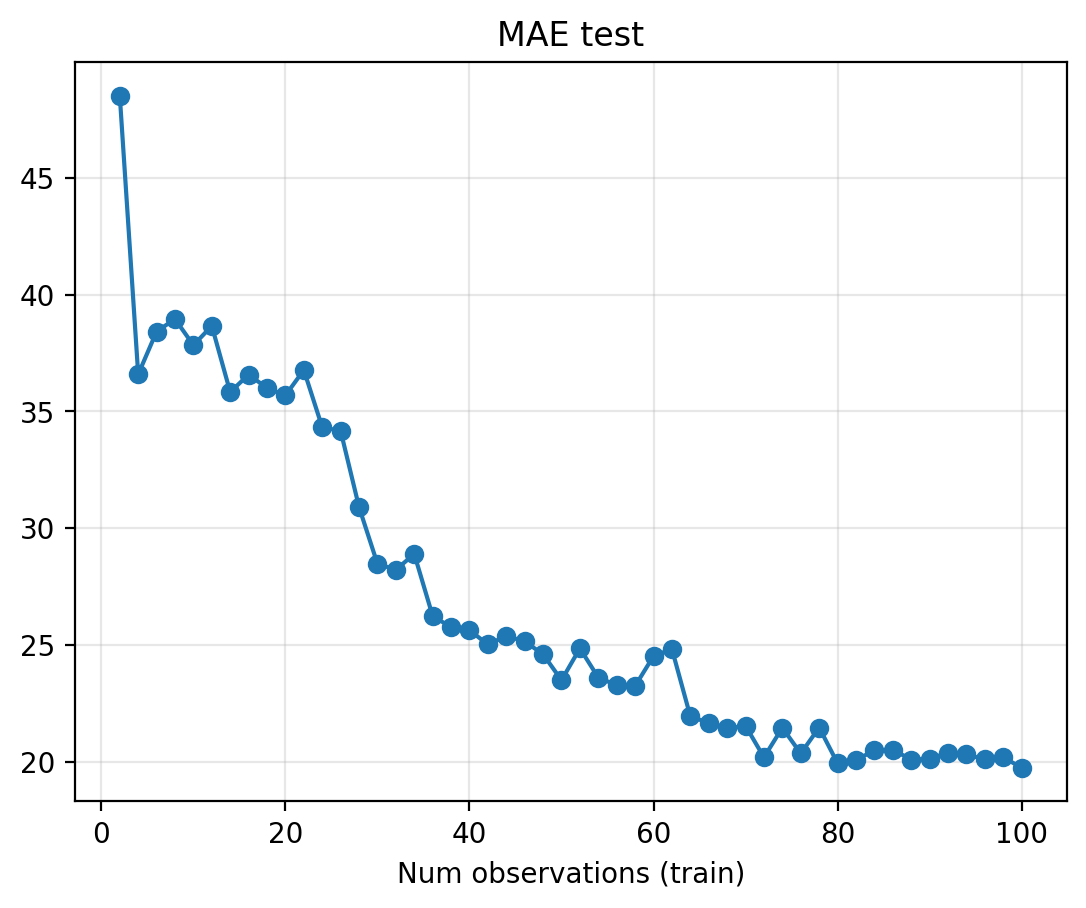

In [124]:
mae_losses.plot(marker="o")
plt.title("MAE test")
plt.grid(alpha=0.3)
plt.xlabel("Num observations (train)")